# Measuring Point Forecast Error.

**In this notebook you will learn:**
    
* How to partition your time series data into training and test sets
* The definition of a point forecast error
* The difference between scale dependent and relative error measures
* How to compute *mean absolute error*
* How to compute *mean absolute percentage error*
* The difference between in-sample and out-of-sample error

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates

import seaborn as sns 
import matplotlib.style as style
style.use('ggplot')

In [2]:
from forecast_tools.datasets import load_emergency_dept

## Load data for this lecture

In [3]:
ed_daily = load_emergency_dept()
ed_daily.shape

(344, 1)

## Train-Test Split

Just like in 'standard' machine learning problems it is important to seperate the data used for model training and model testing.  A key difference with time series forecasting is that you must take the temporal ordering of data into account. 

In [4]:
ed_daily.shape[0]

344

In [5]:
train_length = ed_daily.shape[0] - 28
train, test = ed_daily.iloc[:train_length], ed_daily.iloc[train_length:]

In [6]:
train.shape

(316, 1)

In [7]:
test.shape

(28, 1)

### IMPORTANT - DO NOT LOOK AT THE TEST SET!

We need to **hold back** a proportion of our data.  This is so we can simulate real forecasting conditions and check a models accuracy on **unseen** data.  We don't want to know what it looks like as that will introduce bias into the forecasting process and mean we overfit our model to the data we hold.

**Remember - there is no such thing as real time data from the future!**

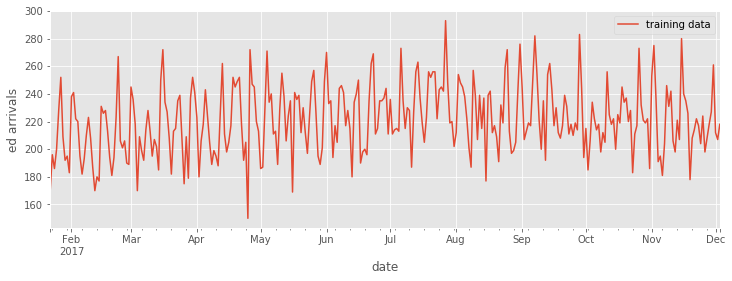

In [8]:
ax = train.plot(figsize=(12,4))
ax.set_ylabel('ed arrivals')
ax.legend(['training data'])

## Point Forecasts

The numbers we produced using the baseline methods in the last lecture are called **point forecasts**.  They are actually the mean value of a **forecast distribution**.  As a reminder:


In [9]:
from forecast_tools.baseline import SNaive

In [10]:
snf = SNaive(period=7)
snf.fit(train)
preds = snf.predict(horizon=28)
preds

array([208., 218., 227., 261., 212., 207., 218., 208., 218., 227., 261.,
       212., 207., 218., 208., 218., 227., 261., 212., 207., 218., 208.,
       218., 227., 261., 212., 207., 218.])

The values in `preds` are point forecasts.  For the time being we will focus on point forecasts.  We will revisit forecast distributions in a future lecture.

## Point Forecast Errors

The point forecast is our best estimate of future observations of the time series.  We use our test set (some times called a holdout set) to simulate real world forecasting.  As our forecasting method has not seen this data before we can measure the difference between the forecast and the ground-truth observed value.  

**Problem: Errors can be both positive and negative so just taking the average will mask the true size of the errors.**  

* There are a large number of forecast error metrics available.  Each has its own pro's and con's.  Here we review some of the most used in practice.
* `forecast_tools.metrics` provides a convenience function `forecast_errors(y_true, y_pred, metrics='all')` that quickly returns a range of the most popular error metrics as well as individual implementations.

In [11]:
from forecast_tools.metrics import forecast_errors, mean_absolute_error, root_mean_squared_error

In [12]:
errors = forecast_errors(y_true=test, y_pred=preds)
errors

{'me': -1.1428571428571428,
 'mae': 26.357142857142858,
 'mse': 1001.2244897959183,
 'rmse': 31.642131562142243,
 'mape': 12.035613307965267,
 'smape': 11.806066246602228}

In [13]:
errors = forecast_errors(y_true=test, y_pred=preds, metrics=['mae', 'mape'])
errors

{'mae': 26.357142857142858, 'mape': 12.035613307965267}

**Calling a specific error metric function**

In [14]:
mean_absolute_error(y_true=test, y_pred=preds)

26.357142857142858

In [15]:
root_mean_squared_error(y_true=test, y_pred=preds)

31.642131562142243

## Comparing forecasting methods using a test (holdout) set.

Let's compare the MAE of the methods on the ED dataset.

In [16]:
#convenience function for creating all objects quickly
from forecast_tools.baseline import baseline_estimators

In [17]:
models = baseline_estimators(seasonal_period=7)

In [18]:
models

{'NF1': <forecast_tools.baseline.Naive1 at 0x1a22778c10>,
 'SNaive': <forecast_tools.baseline.SNaive at 0x1a22778c90>,
 'Average': <forecast_tools.baseline.Average at 0x1a22778cd0>,
 'Drift': <forecast_tools.baseline.Drift at 0x1a22778d10>,
 'Ensemble': <forecast_tools.baseline.EnsembleNaive at 0x1a22778d50>}

In [19]:
HORIZON = len(test)

print(f'{HORIZON}-Step MAE\n----------')
for model_name, model in models.items():
    model.fit(train)
    preds = model.predict(HORIZON)
    mae = mean_absolute_error(y_true=test, y_pred=preds)
    print(f'{model_name}: {mae:.1f}')

28-Step MAE
----------
NF1: 23.4
SNaive: 26.4
Average: 23.7
Drift: 23.6
Ensemble: 23.6
